## Setup

## Installing NL2SQL from a fork / feature branch

In [ ]:
USER = "GoogleCloudPlatform"
BRANCH = "dev"
!pip install -qqq git+https://github.com/{USER}/nl2sql.git@{BRANCH}
!pip install -qq loguru
from IPython.display import HTML, display, clear_output
clear_output()
display(
  HTML(
    f"""
    <h1><span>Installed NL2SQL Library</span></h1>
    <span>Installed Branch : <code>{BRANCH}</code></span>
    """
  )
)

## Auth and Environment Setup

In [ ]:
import warnings
import vertexai
from loguru import logger
from sqlalchemy.exc import SAWarning
from google.colab import auth, data_table

auth.authenticate_user()
activeaccounts = !gcloud config get-value account
warnings.filterwarnings("ignore", category=SAWarning)
!pip install -qq ipython-autotime
%load_ext autotime
clear_output()

In [ ]:
PROJECT_ID = "<project-id>"
!gcloud config set project $PROJECT_ID
vertexai.init(project=PROJECT_ID, location="us-central1")

## Dataset Setup
If you already have a BQ dataset you want to try with NL2SQL, please provide the name of the dataset in `dataset_name` below.

If you want to try NL2SQL with a dummy dataset, leave this blank and we will create a dummy dataset in the project defined above.

In [ ]:
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

client = bigquery.Client()

dataset_name = " "
dataset_name = dataset_name.strip()
bigquery_connection_string = None
if dataset_name:
  print(f"Checking if dataset {dataset_name} exists in {PROJECT_ID}.")
  try:
    client.get_dataset(f"{PROJECT_ID}.{dataset_name}")
  except NotFound as e:
    raise RuntimeError(
      f"Dataset {dataset_name} does not exist in {PROJECT_ID}. Please provide a"
      f" valid dataset name, or leave the field blank to use a dummy dataset."
    ) from e
  else:
    print("Dataset found, proceeding.")
    bigquery_connection_string = f"bigquery://{PROJECT_ID}/{dataset_name}"
else:
  dataset_name = "libraries_io"
  try:
    client.get_dataset(f"{PROJECT_ID}.{dataset_name}")
    print(
      f"The dummy dataset {dataset_name} is already present in {PROJECT_ID}. "
      f"This dataset will be used henceforth, please ensure it has valid data."
    )
    bigquery_connection_string = f"bigquery://{PROJECT_ID}/{dataset_name}"
  except NotFound as e:
    !gcloud services enable bigquerydatatransfer.googleapis.com
    !bq mk --dataset --location=US {PROJECT_ID}:{dataset_name}
    !bq cp --clone -n bigquery-public-data:libraries_io.dependencies {PROJECT_ID}:libraries_io.dependencies
    !bq cp --clone -n bigquery-public-data:libraries_io.projects {PROJECT_ID}:libraries_io.projects
    !bq cp --clone -n bigquery-public-data:libraries_io.projects_with_repository_fields {PROJECT_ID}:libraries_io.projects_with_repository_fields
    !bq cp --clone -n bigquery-public-data:libraries_io.repositories {PROJECT_ID}:libraries_io.repositories
    !bq cp --clone -n bigquery-public-data:libraries_io.repository_dependencies {PROJECT_ID}:libraries_io.repository_dependencies
    !bq cp --clone -n bigquery-public-data:libraries_io.tags {PROJECT_ID}:libraries_io.tags
    !bq cp --clone -n bigquery-public-data:libraries_io.versions {PROJECT_ID}:libraries_io.versions
    clear_output()
    bigquery_connection_string = f"bigquery://{PROJECT_ID}/libraries_io"
  finally:
    assert isinstance(bigquery_connection_string, str)
    print(
      "\n", "="*25, "\n",
      f"\ndataset_name = \"{dataset_name}\"",
      f"\nbigquery_connection_string = \"{bigquery_connection_string}\"\n"
    )

## Usage

### Custom Prompting

This example shows how to provide a custom prompt for the SQL Generation step. This is useful for providing custom instructions to the LLM, and can also be used as a crude way to provide custom few-shot examples.
> **Note:- The custom prompt is a Jinja2 template, and has access to certain variables that can be leveraged to render the prompt.**



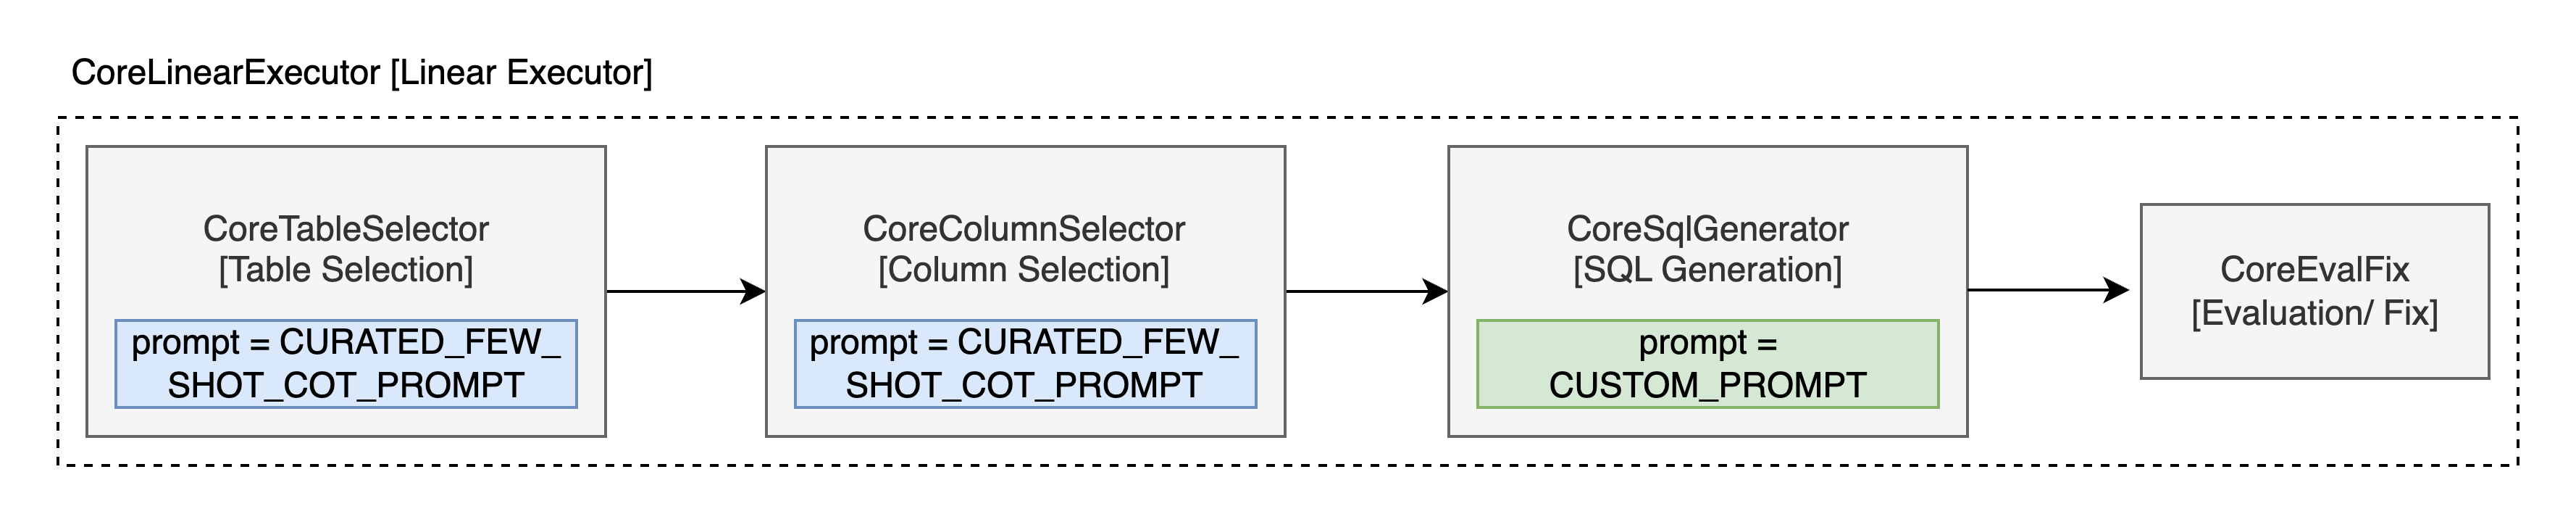

## Setting up LLM and default Table and Column selectors

In [ ]:
from loguru import logger
from nl2sql.datasets import Dataset
from nl2sql.llms.vertexai import VertexAI
from nl2sql.tasks.table_selection.core import CoreTableSelector, prompts as cts_prompts
from nl2sql.tasks.column_selection.core import CoreColumnSelector, prompts as ccs_prompts
from nl2sql.tasks.sql_generation.core import CoreSqlGenerator, prompts as csg_prompts

MODEL_NAME = "gemini-1.5-flash-001" # @param {type:"string"}
TEMPERATURE = 0.1 # @param {type:"number"}
MAX_OUTPUT_TOKENS = 8000 # @param {type:"number"}

llm = VertexAI(model_name=MODEL_NAME, temperature=TEMPERATURE, max_output_tokens=MAX_OUTPUT_TOKENS)
ds = Dataset.from_connection_strings(
  name_connstr_map={dataset_name: bigquery_connection_string}
)
db = ds.get_database(dataset_name)

logger.disable("nl2sql.datasets.base")
table_selector = CoreTableSelector(llm=llm, prompt=cts_prompts.CURATED_FEW_SHOT_COT_PROMPT)
column_selector = CoreColumnSelector(llm=llm, prompt=ccs_prompts.CURATED_FEW_SHOT_COT_PROMPT)
logger.enable("nl2sql.datasets.base")

## Defining a custom prompt for SQL Generation

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.output_parsers import ResponseSchema, StructuredOutputParser

sqlgen_custom_prompt_template = (
  "You are a senior business analyst and an expert in SQL programming. "
  "Carefully analyse the following table description(s):\n"
  "{% for dbbname, dbdesc in db_descriptor.items() %}"
  "{% for tabname, tabdesc in dbdesc.items() %}"
  "\nTable Name: {{tabdesc['table_name']}}"
  "\n\nThis is the CREATE statement used to create this table:"
  "{{tabdesc['table_creation_statement']}}"
  "\n\nThis table has the following columns :"
  "{% for colname, coldesc in tabdesc['col_descriptor'].items() %}"
  "\n{{'{:>4}'.format(loop.index)}}. {{colname}}"
  "\n      This column is of type {{coldesc['col_type']}} "
  "and is {{ '' if coldesc['col_nullable'] else 'non-'}}nullable."
  "{% if coldesc['col_pk'] %}"
  " This column is the primary key for the table."
  "{% endif %}"
  "{% if coldesc['col_defval'] is not none %}"
  " The default value of this column is {{coldesc['col_defval']}}."
  "{% endif %}"
  "{% if coldesc['col_description'] is not none %}"
  " Description: {{coldesc['col_description']}}."
  "{% endif %}"
  "{% if coldesc['col_enum_vals'] %}"
  " This column can have only these values: \"{{coldesc['col_enum_vals']|join('\", \"')}}\"."
  "{% endif %}"
  "{% endfor %}"
  "\n\nHere are a few sample rows from this table:"
  "\n{{tabdesc['table_sample_rows']}}\n"
  "{% endfor %}"
  "{% endfor %}"
  "\nYou are also given the following question:\n"
  "{{question}}\n\n"
  "Your task is to write a SQL statement to answer the above question. "
  "Carefully analyse each table and column and make sure the SQL statement "
  "you write is syntactically correct and answers the asked question "
  "accurately, while only using the tables and columns from above. Before "
  "creating the SQL Query, list down your thoughts around the question and "
  "your approach for solving it. After that, ensure you provide the correct "
  "SQL Query. {{format_instructions}}\n\n Final Answer: "
  "{% if answer %}"
  "\n```json\n{"
  "\n\t\"thoughts\": {{thoughts|join(' ')|tojson}},"
  "\n\t\"query\": {{answer|tojson}}"
  "\n}```"
  "{% endif %}"
)

sqlgen_output_instructions = StructuredOutputParser.from_response_schemas(
  [
    ResponseSchema(
      name="thoughts",
      description=(
        "A short analysis of the question and available tables and "
        "columns, demonstrating the thought process behind how the "
        "query should be built."
      ),
    ),
    ResponseSchema(
      name="query",
      description=(
        "The correct SQL Query to answer the asked question. This "
        "query should only contain information from above and not "
        "use any external information. This is extremely crucial, "
        "ensure that this is correct and included."
      ),
    ),
  ]
)

## Defining custom Examples

In [ ]:
custom_examples = [
  {
    "dataset_name": "libraries_io",
    "dataset_connstr": bigquery_connection_string,
    "data_filter": [
      "libraries_io.dependencies.*",
      "libraries_io.repository_dependencies.*"
    ],
    "question": "Top 10 individual projects with the highest number of runtime dependencies",
    "thoughts": [
      "The question asks for the top 10 individual projects with the highest number of runtime dependencies.",
      "This means that we need to find the projects with the highest number of dependencies where the dependency_kind is 'runtime'.",
      "We can do this by first filtering the 'dependencies' table to only include rows where the dependency_kind is 'runtime'.",
      "Then, we can group the results by the project_name and count the number of dependencies for each project.",
      "Finally, we can order the results by the count of dependencies in descending order and select the top 10 projects."
    ],
    "answer": "SELECT project_name, COUNT(*) AS dependency_count FROM dependencies WHERE dependency_kind = 'runtime' GROUP BY project_name ORDER BY dependency_count DESC LIMIT 10"
  },
  {
    "dataset_name": "libraries_io",
    "dataset_connstr": bigquery_connection_string,
    "data_filter": [
      "libraries_io.projects_with_repository_fields.*"
    ],
    "question": "What is the name of the project with the highest source rank?",
    "thoughts": [
      "The question asks for the name of the project with the highest source rank.",
      "The table 'projects_with_repository_fields' contains the 'name' and 'sourcerank' columns, which are relevant to the question.",
      "To answer the question, we need to find the maximum 'sourcerank' and then retrieve the corresponding 'name'."
    ],
    "answer": "SELECT name FROM projects_with_repository_fields WHERE sourcerank = (SELECT MAX(sourcerank) FROM projects_with_repository_fields)"
  },
]

## Extracting context for custom examples

In [ ]:
from nl2sql.datasets import Dataset

example_dataset = Dataset.from_connection_strings(
  name_connstr_map={
    e["dataset_name"]: e["dataset_connstr"]
    for e in custom_examples
  }
)

extended_examples = [
  {
    **e,
    **{
      "db_descriptor": v for v in [{
        db.name: db.descriptor
        for db in (
          example_dataset
          .filter(filters=e["data_filter"], filter_type="only")
          .databases.values()
        )
        if db.descriptor
      }] if v
    }
  }
  for e in custom_examples
]

## Creating a custom-example SQL Generator


In [ ]:
from langchain.prompts.few_shot import FewShotPromptTemplate

base_prompt = PromptTemplate.from_template(
  template=sqlgen_custom_prompt_template,
  template_format="jinja2",
)
few_shot_prompt=FewShotPromptTemplate(
  example_prompt=base_prompt,
  input_variables=base_prompt.input_variables,
  suffix=base_prompt.template,
  examples=extended_examples,
  template_format=base_prompt.template_format,
)

logger.disable("nl2sql.datasets.base")
sqlgen_custom_examples = csg_prompts.custom_prompt(
  prompt_template=few_shot_prompt,
  parser=sqlgen_output_instructions,
  post_processor=lambda x: x.get("query")
)
sql_generator_custom_examples = CoreSqlGenerator(llm=llm, prompt=sqlgen_custom_examples)
logger.enable("nl2sql.datasets.base")

## Creating an executor 
Using the previously defined `table_selector`, `column_selector` and `sql_generator_custom_examples`


In [ ]:
from nl2sql.executors.linear_executor.core import CoreLinearExecutor

custom_example_executor = CoreLinearExecutor.from_connection_string_map(
  {
    dataset_name: bigquery_connection_string
  },
  core_table_selector = table_selector,
  core_column_selector = column_selector,
  core_sql_generator = sql_generator_custom_examples
)

## Running the executor

In [ ]:
QUESTION = "Top 10 projects names with the highest number of published versions and the stars count of their repositories"

custom_example_result = custom_example_executor(
    db_name= dataset_name,
    question = QUESTION
)
print("\n\n", "="*50, "Generated SQL", "="*50, "\n\n")
print("Result ID:", custom_example_result.result_id, "\n\n")
print(custom_example_result.generated_query)

## SQL Execution

In [ ]:
custom_example_df = custom_example_executor.fetch_result(custom_example_result)
data_table.DataTable(custom_example_df)